## Using workload and SQL metrics to predict execution time

### Import the libraries and define functions that compute SQL metrics

In [2]:
from multiprocessing import Process, Queue
import glob
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import math as m
import numpy as np
%matplotlib inline
plt.style.use('ggplot')

def collect_sqlm(num1,num2,queue):
    for i in range (num1,num2):
        tablenames = []
        operand_size = 0
        index_size = 0
        log_os = 0
        log_is = 0
        regex =[]
        query = fdf.loc[i,('query')].upper()
        query = re.sub(r',\s+', ',', query)
        if re.search(r'\ASELECT|INSERT|DELETE',query):
            regex = re.findall(r'(?<=FROM|JOIN|INTO)\s+[\w.]+',query)
        if re.search(r'\AUPDATE',query):
            regex = re.findall(r'(?<=UPDATE)\s+[\w.]+',query)
        if re.search(r'\AMERGE',query):
            regex1 = re.findall(r'(?<=INTO)\s+[\w.]+',query)
            regex2 = re.findall(r'(?<=MERGE)\s+[\w.]+',query)
            regex = regex1+regex2
        for item in regex:
            for table in item.split(','):
                tablenames.append(table)
        for table in tablenames:
            tableschema = ''
            tablename = ''
            if len(table.split('.')) == 2:
                tableschema = table.split('.')[0]
                tablename = table.split('.')[1]
                try:
                    operand_size = operand_size + sizedf.loc[tableschema.strip(),tablename.strip()].object_size
                    
                except KeyError:
                    operand_size = 0
                try:
                    index_size = index_size + sizedf.loc[tableschema.strip(),tablename.strip()].index_size
                except KeyError:
                    index_size = 0
        num_operations = 0
        
        base_operation = 'SELECT|INSERT|DELETE|UPDATE|MERGE|VALUES'
        set_operation = 'JOIN|UNION'
        final_operation = 'ORDER BY| GROUP BY'
        regex = re.findall(base_operation,query)
        num_operations = num_operations+len(regex)
        regex = re.findall(set_operation,query)
        num_operations = num_operations+len(regex)
        regex = re.findall(final_operation,query)
        num_operations = num_operations+len(regex)
        
        num_filters = 0
        regex = re.findall(r'WHERE',query)
        num_filters = len(regex)
        regex = re.findall(r' AND | OR ',query)
        num_filters = num_filters + len(regex)
        
        objects_size_tuple = (i,operand_size/1024/1024,index_size/1024/1024,num_operations,num_filters)
        queue.put(objects_size_tuple)
    queue.put((-1,-1,-1,-1,-1))
    return

def read_queue(queue):
    global sizobj_list
    global num_procs
    count = 0
    while True:
            location , operand_size,index_size,num_operations,num_filters = queue.get()
            if (operand_size == -1):
                count = count + 1
                #print (count)
            else:
                sizeobj_list.append((location,operand_size,index_size,num_operations,num_filters))
            if (count == num_procs):
                print ("done")
                break
    return

### Read the raw data for SQL metrics, Workload Metrics and Object sizes

In [3]:
path = r'/data/developer/python'    
allFiles = glob.glob(path + "/SQL_Metrics*.csv")     
list_ = []
notvalues = []
for file_ in allFiles:
    regex = re.search('SQL_Metrics_([0-9]*-[0-9]*-[0-9]*)-([0-9]*)', file_)
    df = pd.read_csv(file_,sep = '@',names = ['stmt_hash','query','exec_time'],index_col=False)
    df['date'] = regex.group(1)
    df['hour'] = regex.group(2)
    df.exec_time = pd.to_numeric(df.exec_time,errors='coerce')
    df.hour = pd.to_numeric(df.hour,errors='coerce')
    list_.append(df)
fdf = pd.concat(list_,ignore_index=True)
fdf = fdf[fdf.exec_time > 0].reset_index().drop('index',axis=1)       



allFiles = glob.glob(path + "/size*.csv")     
list_ = []
for file_ in allFiles:
    regex = re.search('size*', file_)
    sizedf = pd.read_csv(file_,sep = '@',names = ['tableschema','tablename','object_size','index_size','lob_size'],index_col=False)
    sizedf = sizedf.set_index(['tableschema', 'tablename'])

plt.style.use('ggplot')



fields = ['time','lock_wait_time','total_section_sort_time','diaglog_write_wait_time','direct_read_time','direct_write_time','log_buffer_wait_time','log_disk_wait_time','pool_read_time','pool_write_time','prefetch_wait_time','total_act_time','total_act_wait_time','total_cpu_time','total_extended_latch_wait_time','span']
path = r'/data/developer/python'    
allFiles = glob.glob(path + "/workload_stats_*.csv")    
list_ = []
for file_ in allFiles:
    regex = re.search('workload_stats_([0-9]*-[0-9]*-[0-9]*)', file_)
    wldf = pd.read_csv(file_,sep = '@',names = fields,index_col=False)
    list_.append(wldf)
final_wldf = pd.concat(list_,ignore_index=True)
final_wldf['hour'] = 0
final_wldf['date'] = 0
for i in range (0,len(final_wldf)):
    regex = re.search('([0-9-]*)T([0-9]*)', final_wldf.loc[i,('time')])
    final_wldf.loc[i,('date')] = regex.group(1)
    final_wldf.loc[i,('hour')] = int(regex.group(2)) + 1 
    
final_wldf = final_wldf.set_index(['date', 'hour'])
final_wldf.drop('time',axis=1,inplace = True)
final_wldf.drop('span',axis=1,inplace = True)

In [31]:
fdf.shape

(891822, 5)

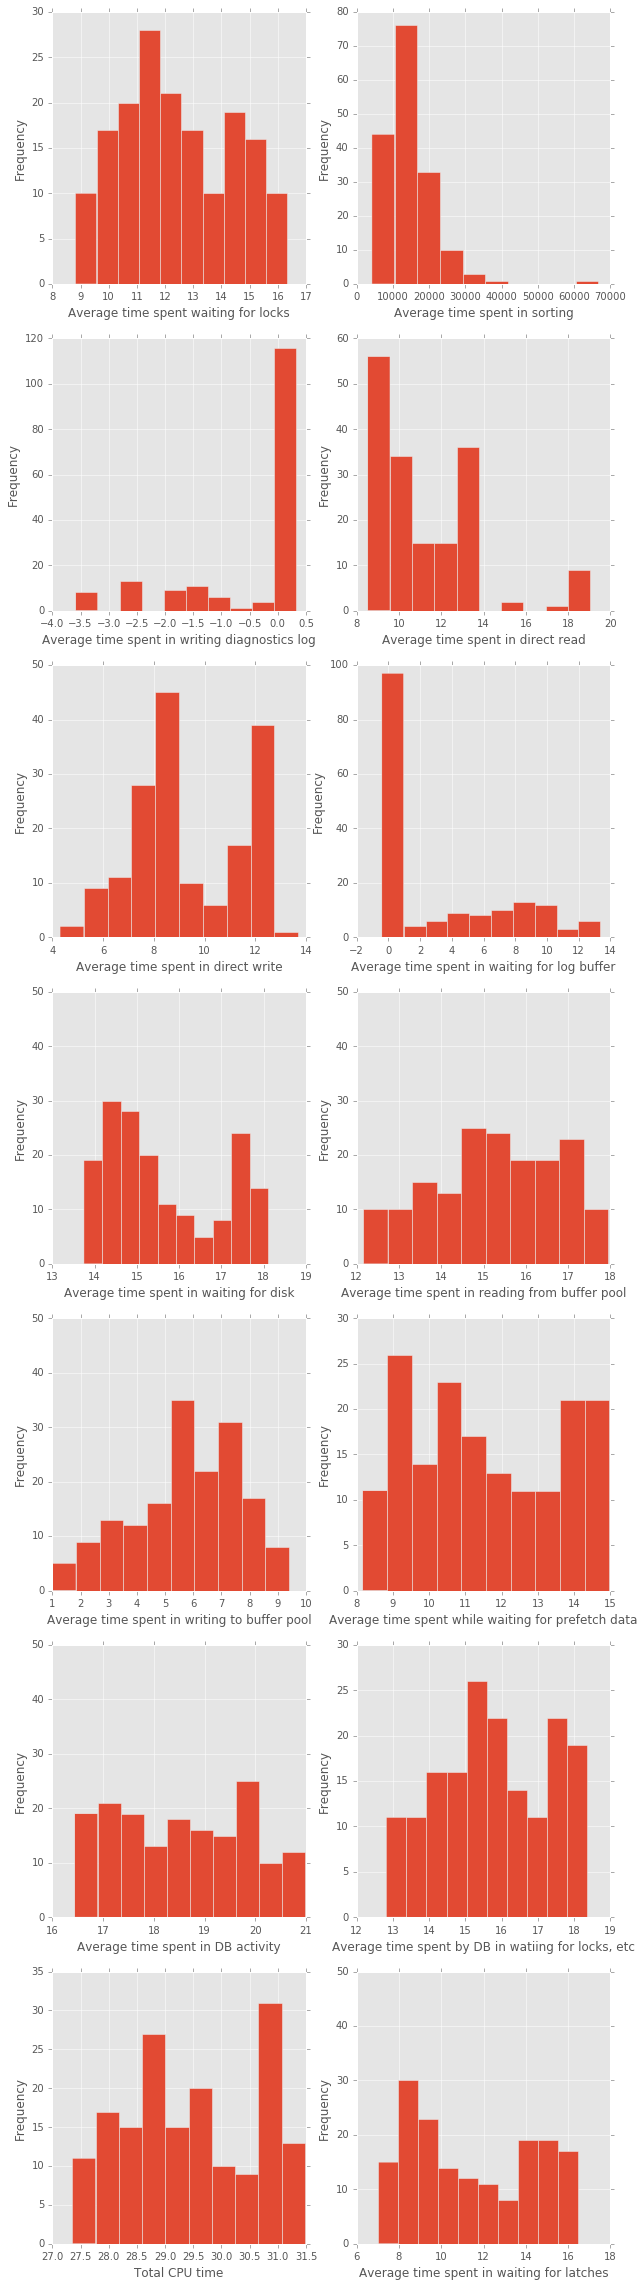

In [6]:
final_wldf['log_lock_wait_time'] = 0
final_wldf['log_total_section_sort_time'] = 0
final_wldf['log_diaglog_write_wait_time'] = 0
final_wldf['log_direct_read_time'] = 0
final_wldf['log_direct_write_time'] = 0
final_wldf['log_log_buffer_wait_time'] = 0
final_wldf['log_log_disk_wait_time'] = 0
final_wldf['log_pool_read_time'] = 0
final_wldf['log_pool_write_time'] = 0
final_wldf['log_prefetch_wait_time'] = 0
final_wldf['log_total_act_time'] = 0
final_wldf['log_total_act_wait_time'] = 0
final_wldf['log_total_cpu_time'] = 0
final_wldf['log_total_extended_latch_wait_time'] = 0
for i in range (0,len(final_wldf)):
        if (final_wldf.iloc[i].lock_wait_time!=0):
           final_wldf.iloc[i,final_wldf.columns.get_loc('log_lock_wait_time')] = m.log2(final_wldf.iloc[i].lock_wait_time)
        if (final_wldf.iloc[i].total_section_sort_time!=0):
           final_wldf.iloc[i,final_wldf.columns.get_loc('log_total_section_sort_time')] = m.log2(final_wldf.iloc[i].total_section_sort_time)
        if (final_wldf.iloc[i].diaglog_write_wait_time!=0):
           final_wldf.iloc[i,final_wldf.columns.get_loc('log_diaglog_write_wait_time')] = m.log2(final_wldf.iloc[i].diaglog_write_wait_time)
        if (final_wldf.iloc[i].direct_read_time!=0):
           final_wldf.iloc[i,final_wldf.columns.get_loc('log_direct_read_time')] = m.log2(final_wldf.iloc[i].direct_read_time)
        if (final_wldf.iloc[i].direct_write_time!=0):
           final_wldf.iloc[i,final_wldf.columns.get_loc('log_direct_write_time')] = m.log2(final_wldf.iloc[i].direct_write_time)
        if (final_wldf.iloc[i].log_buffer_wait_time!=0):
           final_wldf.iloc[i,final_wldf.columns.get_loc('log_log_buffer_wait_time')] = m.log2(final_wldf.iloc[i].log_buffer_wait_time)
        if (final_wldf.iloc[i].log_disk_wait_time!=0):
           final_wldf.iloc[i,final_wldf.columns.get_loc('log_log_disk_wait_time')] = m.log2(final_wldf.iloc[i].log_disk_wait_time)
        if (final_wldf.iloc[i].pool_read_time!=0):
           final_wldf.iloc[i,final_wldf.columns.get_loc('log_pool_read_time')] = m.log2(final_wldf.iloc[i].pool_read_time)
        if (final_wldf.iloc[i].pool_write_time!=0):
           final_wldf.iloc[i,final_wldf.columns.get_loc('log_pool_write_time')] = m.log2(final_wldf.iloc[i].pool_write_time)
        if (final_wldf.iloc[i].prefetch_wait_time!=0):
           final_wldf.iloc[i,final_wldf.columns.get_loc('log_prefetch_wait_time')] = m.log2(final_wldf.iloc[i].prefetch_wait_time)
        if (final_wldf.iloc[i].total_act_time!=0):
           final_wldf.iloc[i,final_wldf.columns.get_loc('log_total_act_time')] = m.log2(final_wldf.iloc[i].total_act_time)
        if (final_wldf.iloc[i].total_act_wait_time!=0):
           final_wldf.iloc[i,final_wldf.columns.get_loc('log_total_act_wait_time')] = m.log2(final_wldf.iloc[i].total_act_wait_time)
        if (final_wldf.iloc[i].total_cpu_time!=0):
           final_wldf.iloc[i,final_wldf.columns.get_loc('log_total_cpu_time')] = m.log2(final_wldf.iloc[i].total_cpu_time)
        if (final_wldf.iloc[i].total_extended_latch_wait_time!=0):
           final_wldf.iloc[i,final_wldf.columns.get_loc('log_total_extended_latch_wait_time')] = m.log2(final_wldf.iloc[i].total_extended_latch_wait_time)
fig, ax = plt.subplots(7,2,figsize=(10,40))
ax[0][0].hist(final_wldf['log_lock_wait_time'])
ax[0][0].set_xlabel('Average time spent waiting for locks')
ax[0][0].set_ylabel('Frequency')
ax[0][1].hist(final_wldf['total_section_sort_time'])
ax[0][1].set_xlabel('Average time spent in sorting')
ax[0][1].set_ylabel('Frequency')
ax[1][0].hist(final_wldf['log_diaglog_write_wait_time'])
ax[1][0].set_xlabel('Average time spent in writing diagnostics log')
ax[1][0].set_ylabel('Frequency')
ax[1][1].hist(final_wldf['log_direct_read_time'])
ax[1][1].set_xlabel('Average time spent in direct read')
ax[1][1].set_ylabel('Frequency')
ax[2][0].set_ylim(0,50)
ax[2][0].hist(final_wldf['log_direct_write_time'])
ax[2][0].set_xlabel('Average time spent in direct write')
ax[2][0].set_ylabel('Frequency')
ax[2][1].hist(final_wldf['log_log_buffer_wait_time'])
ax[2][1].set_xlabel('Average time spent in waiting for log buffer')
ax[2][1].set_ylabel('Frequency')
ax[3][0].set_ylim(0,50)
ax[3][0].hist(final_wldf['log_log_disk_wait_time'])
ax[3][0].set_xlabel('Average time spent in waiting for disk')
ax[3][0].set_ylabel('Frequency')
ax[3][1].set_ylim(0,50)
ax[3][1].hist(final_wldf['log_pool_read_time'])
ax[3][1].set_xlabel('Average time spent in reading from buffer pool')
ax[3][1].set_ylabel('Frequency')
ax[4][0].set_ylim(0,50)
ax[4][0].hist(final_wldf['log_pool_write_time'])
ax[4][0].set_xlabel('Average time spent in writing to buffer pool')
ax[4][0].set_ylabel('Frequency')
ax[4][1].hist(final_wldf['log_prefetch_wait_time'])
ax[4][1].set_xlabel('Average time spent while waiting for prefetch data')
ax[4][1].set_ylabel('Frequency')
ax[5][0].set_ylim(0,50)
ax[5][0].hist(final_wldf['log_total_act_time'])
ax[5][0].set_xlabel('Average time spent in DB activity')
ax[5][0].set_ylabel('Frequency')
ax[5][1].hist(final_wldf['log_total_act_wait_time'])
ax[5][1].set_xlabel('Average time spent by DB in watiing for locks, etc')
ax[5][1].set_ylabel('Frequency')
ax[6][0].hist(final_wldf['log_total_cpu_time'])
ax[6][0].set_xlabel('Total CPU time')
ax[6][0].set_ylabel('Frequency')
ax[6][1].set_ylim(0,50)
ax[6][1].hist(final_wldf['log_total_extended_latch_wait_time'])
ax[6][1].set_xlabel('Average time spent in waiting for latches')
ax[6][1].set_ylabel('Frequency')

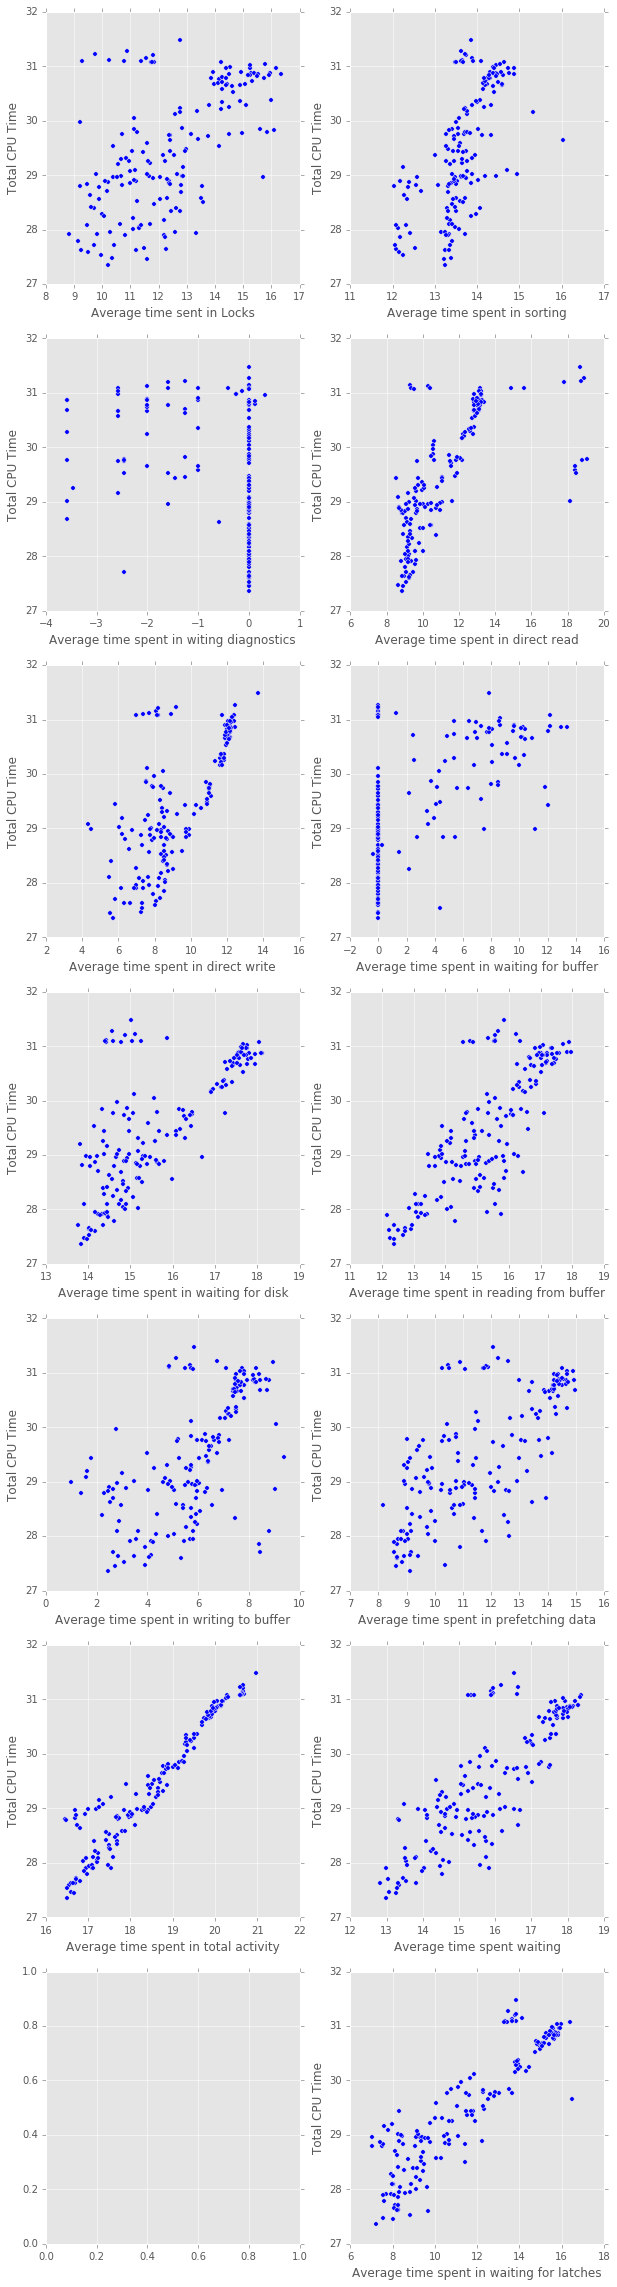

In [14]:
fig, ax = plt.subplots(7,2,figsize=(10,40))
ax[0][0].scatter(final_wldf['log_lock_wait_time'],final_wldf['log_total_cpu_time'])
ax[0][0].set_xlabel('Average time sent in Locks')
ax[0][0].set_ylabel('Total CPU Time')
ax[0][1].scatter(final_wldf['log_total_section_sort_time'],final_wldf['log_total_cpu_time'])
ax[0][1].set_xlabel('Average time spent in sorting')
ax[0][1].set_ylabel('Total CPU Time')
ax[1][0].scatter(final_wldf['log_diaglog_write_wait_time'],final_wldf['log_total_cpu_time'])
ax[1][0].set_xlabel('Average time spent in witing diagnostics')
ax[1][0].set_ylabel('Total CPU Time')
ax[1][1].scatter(final_wldf['log_direct_read_time'],final_wldf['log_total_cpu_time'])
ax[1][1].set_xlabel('Average time spent in direct read')
ax[1][1].set_ylabel('Total CPU Time')
ax[2][0].scatter(final_wldf['log_direct_write_time'],final_wldf['log_total_cpu_time'])
ax[2][0].set_xlabel('Average time spent in direct write')
ax[2][0].set_ylabel('Total CPU Time')
ax[2][1].scatter(final_wldf['log_log_buffer_wait_time'],final_wldf['log_total_cpu_time'])
ax[2][1].set_xlabel('Average time spent in waiting for buffer')
ax[2][1].set_ylabel('Total CPU Time')
ax[3][0].scatter(final_wldf['log_log_disk_wait_time'],final_wldf['log_total_cpu_time'])
ax[3][0].set_xlabel('Average time spent in waiting for disk')
ax[3][0].set_ylabel('Total CPU Time')
ax[3][1].scatter(final_wldf['log_pool_read_time'],final_wldf['log_total_cpu_time'])
ax[3][1].set_xlabel('Average time spent in reading from buffer')
ax[3][1].set_ylabel('Total CPU Time')
ax[4][0].scatter(final_wldf['log_pool_write_time'],final_wldf['log_total_cpu_time'])
ax[4][0].set_xlabel('Average time spent in writing to buffer')
ax[4][0].set_ylabel('Total CPU Time')
ax[4][1].scatter(final_wldf['log_prefetch_wait_time'],final_wldf['log_total_cpu_time'])
ax[4][1].set_xlabel('Average time spent in prefetching data')
ax[4][1].set_ylabel('Total CPU Time')
ax[5][0].scatter(final_wldf['log_total_act_time'],final_wldf['log_total_cpu_time'])
ax[5][0].set_xlabel('Average time spent in total activity')
ax[5][0].set_ylabel('Total CPU Time')
ax[5][1].scatter(final_wldf['log_total_act_wait_time'],final_wldf['log_total_cpu_time'])
ax[5][1].set_xlabel('Average time spent waiting')
ax[5][1].set_ylabel('Total CPU Time')
ax[6][1].scatter(final_wldf['log_total_extended_latch_wait_time'],final_wldf['log_total_cpu_time'])
ax[6][1].set_xlabel('Average time spent in waiting for latches')
ax[6][1].set_ylabel('Total CPU Time')

### Create the data frame with all the predictors and the response variable

In [15]:
import time
queue = Queue()
num_procs = 8
sizeobj_list = []
pro_list = []
num_rows = len(fdf)
group_size = int(num_rows/num_procs)
for group_num in range(0,num_procs):
    num1 = group_num*(group_size)
    num2 = num1 + group_size - 1
    proc = Process(target=collect_sqlm, args=(num1,num2,queue))
    pro_list.append(proc)

start = time.time()
for p in pro_list:
    p.start()
    
read_queue(queue)

sizeobj_df = pd.DataFrame(sizeobj_list, columns=['location', 'operand_size','index_size','num_operations','num_filters']).set_index('location')

final_df_sqlm = fdf.merge(sizeobj_df, left_index = True, right_index=True, how='inner').reset_index().drop('index',axis = 1)

sqlm_df = final_df_sqlm[final_df_sqlm.operand_size != 0]

processtime = time.time() - start
print("Took {} seconds with 8 processes.".format(processtime))

sqlm_final_df = sqlm_df.groupby(['date','hour'])['operand_size','index_size','num_operations','num_filters','exec_time'].mean()

final_df = sqlm_final_df.merge(final_wldf, left_index = True, right_index=True, how='inner')
print(final_df.shape)

done
Took 99.93394827842712 seconds with 8 processes.
(154, 33)


In [32]:
sqlm_df.head()

,stmt_hash,query,exec_time,date,hour,operand_size,index_size,num_operations,num_filters
0,1946530544,"select SCIQUEST.DOCUMENTSEARCHQUERY.QUERYID, O...",0.034662,2016-06-12,2,0.007080,0.011963,2,2
1,1246705100,"SELECT ObjectId, GroupId, CreateDate, UpdateDa...",0.033333,2016-06-12,2,0.000244,0.000244,3,0
2,594601300,SELECT ObjectId FROM Fulfillment.IncrIndexing...,0.125000,2016-06-12,2,0.000732,0.000610,1,2
5,581665337,"SELECT SupplierId, SupplierAddressId, OrgId, C...",0.101266,2016-06-12,2,0.703613,0.734863,1,1
6,1637037209,"SELECT ObjectId, GroupId, CreateDate, UpdateDa...",0.026667,2016-06-12,2,0.000244,0.000244,3,0


In [27]:
final_df = final_df.reset_index()
final_df = final_df[final_df.index!=6]
final_df = final_df[final_df.index!=135]
final_df = final_df[final_df.index!=148]
final_df = final_df[final_df.index!=147]
final_df = final_df[final_df.index!=139]
final_df = final_df[final_df.index!=140]
final_df = final_df[final_df.index!=138]

### Log transform of response variable

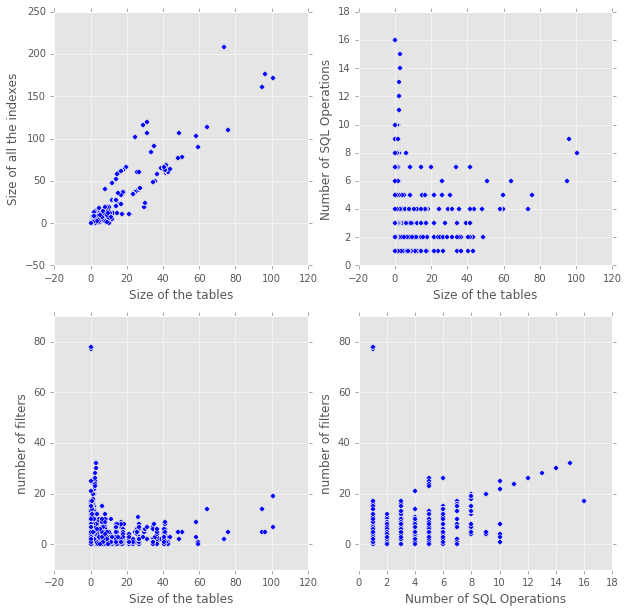

In [16]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0][0].scatter(sqlm_df['operand_size'],sqlm_df['index_size'])
ax[0][0].set_xlabel('Size of the tables')
ax[0][0].set_ylabel('Size of all the indexes')

ax[0][1].scatter(sqlm_df['operand_size'],sqlm_df['num_operations'])
ax[0][1].set_xlabel('Size of the tables')
ax[0][1].set_ylabel('Number of SQL Operations')

ax[1][0].scatter(sqlm_df['operand_size'],sqlm_df['num_filters'])
ax[1][0].set_xlabel('Size of the tables')
ax[1][0].set_ylabel('number of filters')

ax[1][1].scatter(sqlm_df['num_operations'],sqlm_df['num_filters'])
ax[1][1].set_xlabel('Number of SQL Operations')
ax[1][1].set_ylabel('number of filters')

In [28]:
final_df['log_exec_time'] = 0
final_df['log_lock_wait_time'] = 0
for i in range (0,len(final_df)):
        final_df.iloc[i,final_df.columns.get_loc('log_exec_time')] = m.log10(final_df.iloc[i].exec_time)

### Linear regression 

In [29]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

#X = final_df[['total_cpu_time','operand_size','num_filters']]
#X = final_df[['operand_size','num_filters','log_total_cpu_time']]
#X = final_df [['log_total_cpu_time','lock_wait_time','operand_size','num_filters','num_operations']]
X = final_df [['operand_size','num_filters','num_operations','log_total_cpu_time']]
y = final_df['log_exec_time']

#Total CPU Time , Lock time out, operand size , number of filters , number of operations 

est = smf.OLS(y, X)

est = est.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_exec_time   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     480.9
Date:                Fri, 23 Sep 2016   Prob (F-statistic):           7.83e-82
Time:                        15:51:06   Log-Likelihood:                -19.713
No. Observations:                 147   AIC:                             47.43
Df Residuals:                     143   BIC:                             59.39
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
operand_size           0.2458      0.104      2.354      0.020         0.039     0.452
num_filters           -4.0137      0.867     -4.629      0.000        -5.728    -2.300
num_operations         2.5848      0.816      3.166      0.002         0.971     4.199
log_total_cpu_time     0.1127      0.022      5.151      0.000         0.069     0.156
==============================================================================
Omnibus:                       64.344   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.445
Skew:                           1.740   Prob(JB):                     5.98e-43
Kurtosis:                       7.431   Cond. No.                     1.50e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

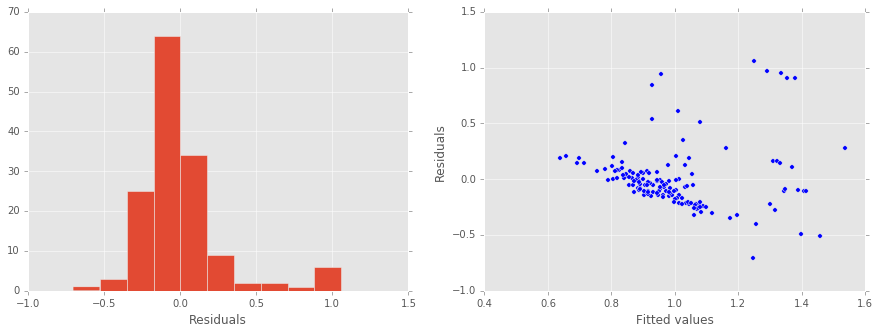

In [227]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].hist(est.resid)
ax[0].set_xlabel('Residuals')
ax[1].scatter(est.fittedvalues,est.resid)
ax[1].set_xlabel('Fitted values')
ax[1].set_ylabel('Residuals')



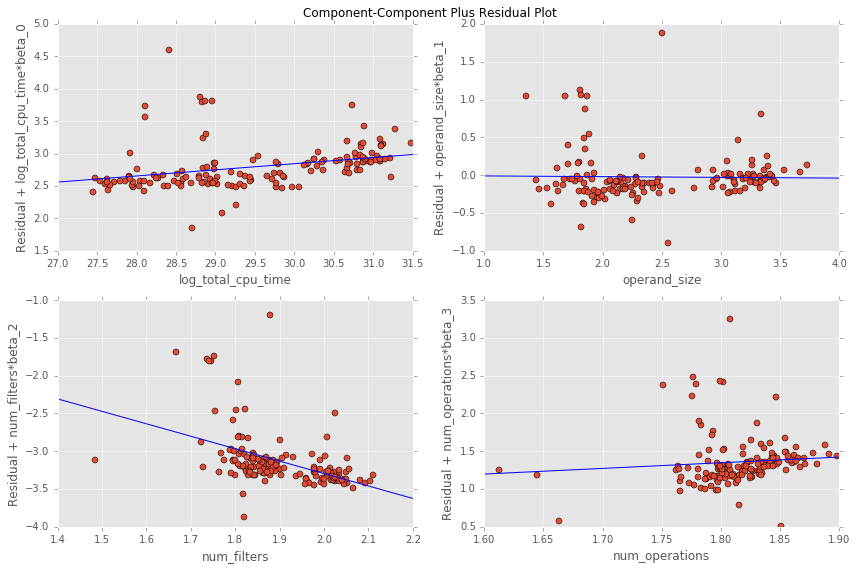

In [186]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_ccpr_grid(est, fig=fig)

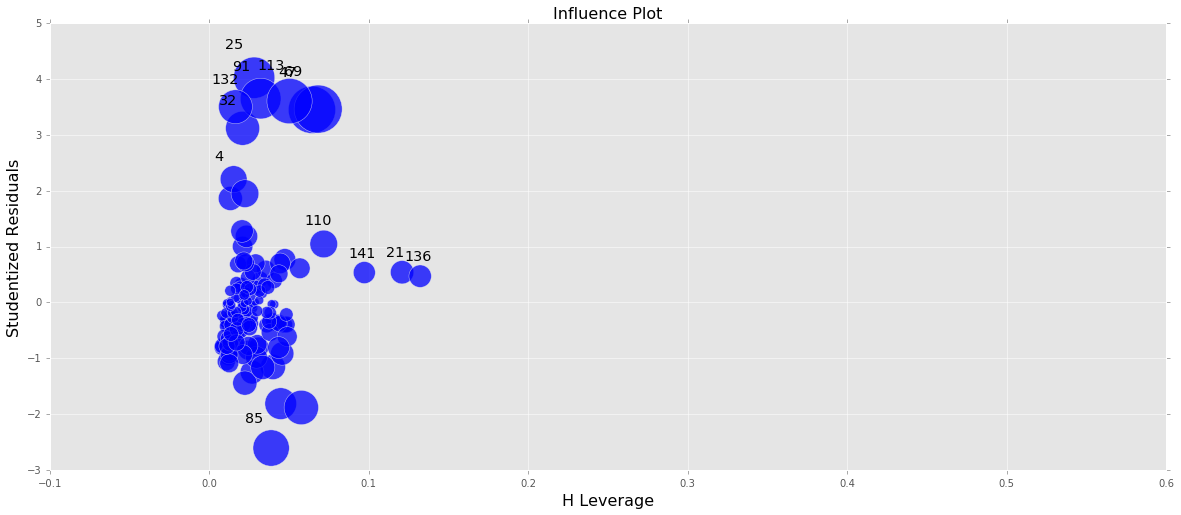

In [33]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlim(-0.1,0.6)
fig = sm.graphics.influence_plot(est, ax=ax, criterion="cooks")
#final_df

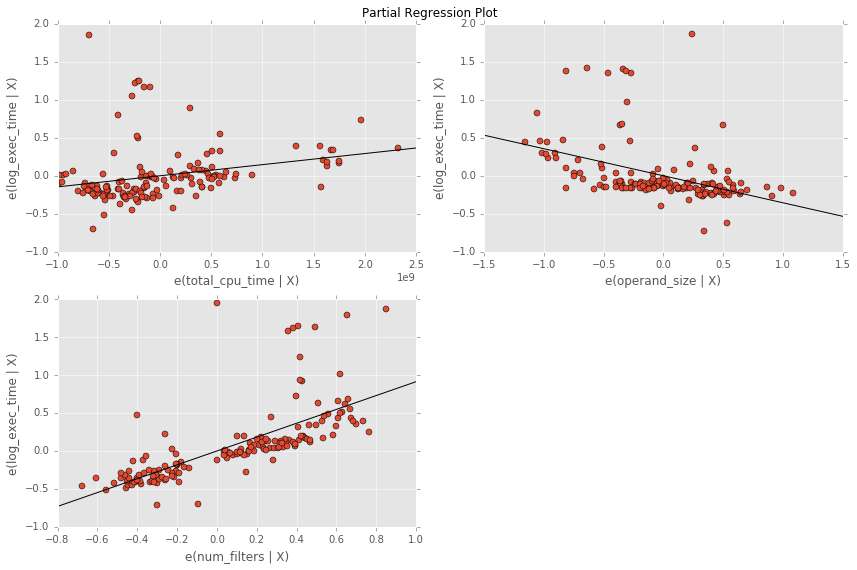

In [12]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(est, fig=fig)

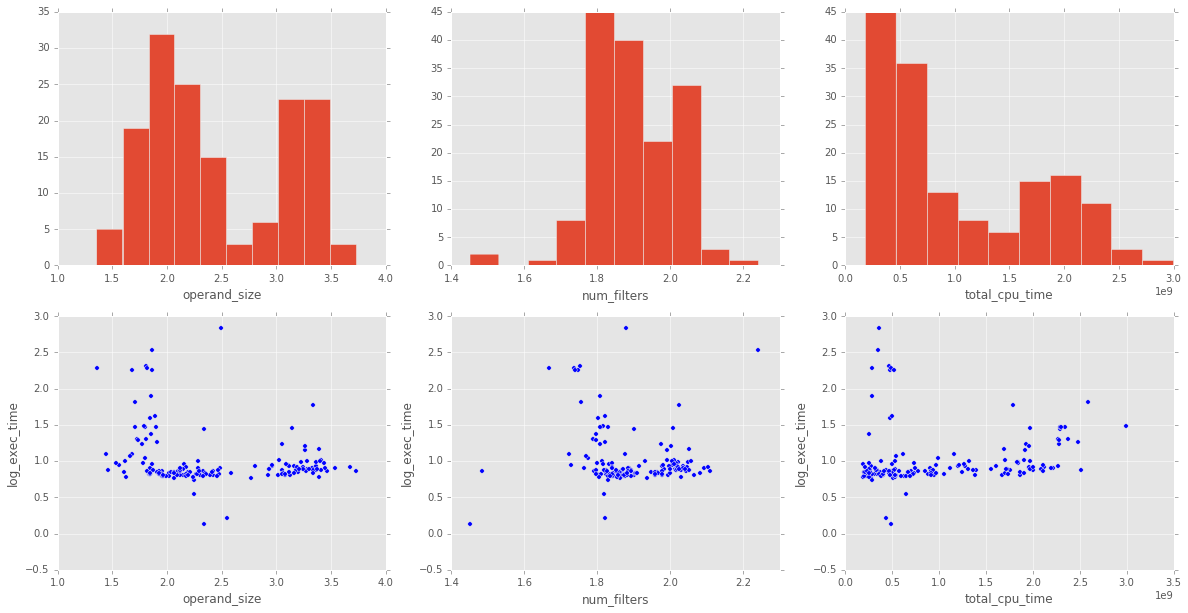

In [35]:
fig,axes = plt.subplots(2,3,figsize=(20,10))
axes[0][0].hist(final_df.operand_size)
axes[0][0].set_xlabel('operand_size')
axes[0][1].hist(final_df.num_filters)
axes[0][1].set_xlabel('num_filters')
axes[0][2].hist(final_df.total_cpu_time)
axes[0][2].set_xlabel('total_cpu_time')
axes[1][0].scatter(final_df.operand_size,final_df.log_exec_time)
axes[1][0].set_xlabel('operand_size')
axes[1][0].set_ylabel('log_exec_time')
axes[1][1].scatter(final_df.num_filters,final_df.log_exec_time)
axes[1][1].set_xlabel('num_filters')
axes[1][1].set_ylabel('log_exec_time')
axes[1][2].scatter(final_df.total_cpu_time,final_df.log_exec_time)
axes[1][2].set_xlabel('total_cpu_time')
axes[1][2].set_ylabel('log_exec_time')